In [13]:
%load_ext autoreload
%autoreload 2

from aeon.datasets import load_regression

import numpy as np
import pandas as pd
import torch
import random
import csv

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
from sklearn import metrics

from weights_parser import WeightsParser
from models import LogisticRegressionWithSummariesAndBottleneck_Wrapper, Mode
from custom_losses import custom_bce_horseshoe
from preprocess_helpers import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError

from itertools import combinations

from tqdm import tqdm
from time import sleep
from helper import *
import collections
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline
import os
import helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
X, y, meta_data = load_regression("AustraliaRainfall", extract_path="/workdir/optimal-summaries-public/data")
print(" Shape of X = ", X.shape)
print(" Shape of y = ", y.shape)
print(" Meta data = ", meta_data)
y

 Shape of X =  (160267, 3, 24)
 Shape of y =  (160267,)
 Meta data =  {'problemname': 'australiarainfall', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': False, 'targetlabel': True, 'class_values': []}


array([ 2.4, 14.4,  0. , ...,  0. ,  0. ,  0. ])

In [15]:
display(pd.DataFrame(X[0]).head())

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,12.5,12.5,11.1,12.2,12.1,12.2,12.2,13.0,13.0,13.7,...,13.7,13.0,13.5,12.2,13.5,12.3,12.6,13.2,13.5,13.3
1,12.8,13.1,12.4,12.6,12.7,12.8,13.0,13.4,13.9,14.3,...,14.3,13.5,14.4,13.7,14.0,13.1,13.3,13.7,13.9,13.9
2,12.1,10.8,11.0,11.6,11.0,11.7,12.1,11.7,12.9,12.2,...,12.9,11.7,11.5,12.1,12.3,11.9,12.1,13.1,13.1,12.6


In [16]:
def preprocess_data(_X, _y):
    data = _X
    # data = (data - data.mean(axis=-1)) / data.std(axis=-1) # normalize
    data = data.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(data)
    data = np.concatenate([data, indicators_3d], axis=-1) # (N x ts_length x 2*changing_dim)
    
    target = _y
    
    return data, target

In [17]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initializeData(r, _X, _y):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.15, random_state = r, stratify = _y)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_train_pt = Variable(tensor_wrap(X_train)).cuda()
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor)).cuda()

    X_val_pt = Variable(tensor_wrap(X_val)).cuda()
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor)).cuda()

    X_test_pt = Variable(tensor_wrap(X_test)).cuda()
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor)).cuda()

    batch_size = 128

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=True, num_workers=0)

    # test_dataset = TensorDataset(X_test_pt, y_test_pt)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader, val_loader, X_test_pt, y_test_pt


In [18]:
def init_cutoffs_to_zero(d):
    return np.zeros(d)


In [19]:
# init the upper and lower thresholds to random values
def init_rand_upper_thresholds(d):
    return np.random.rand(d)

def init_rand_lower_thresholds(d):
    return np.random.rand(d) - 1


In [6]:
def initializeModel(c, input_dim, changing_dim, time_len, output_dim):
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                c,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None,
                                                time_len=time_len,
                                                opt_lr = 2e-4,
                                                opt_weight_decay = 2e-05,
                                                l1_lambda=0.001,
                                                cos_sim_lambda=0.01,
                                                output_dim = output_dim,
                                                mode = Mode
                                                )
    logregbottleneck.cuda()
    return logregbottleneck

In [7]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)


In [21]:

mae_ = MeanAbsoluteError().cuda()
mape_ = MeanAbsolutePercentageError().cuda()
mse_ = MeanSquaredError().cuda()

def objective(r, num_concept, model_path):
    set_seed(r)
    data, target = preprocess_data(X, y)
    input_dim = data.shape[2]
    changing_dim = X[0].shape[0]
    ts_length = data.shape[1]
    train_loader, val_loader, X_test, y_test = initializeData(1, data, target)
    model = initializeModel(num_concept, input_dim, changing_dim, ts_length, 1).cuda()
    
    train_loss, val_loss = model.fit(train_loader, val_loader, None, model_path.format(num_concept), 1000)
    
    probs = model.forward_probabilities(X_test)
    
    mae = mae_(probs, y_test).item()
    mape = mape_(probs, y_test).item()
    mse = mae_(probs, y_test).item()
    
    return val_loss, mae, mape, mse, model


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [11]:
# write results to csv
def write_row_to_csv(experiment_folder, row, filename = "gridsearch"):
    with open('{file_path}.csv'.format(file_path=os.path.join(experiment_folder, filename)), 'a+') as csvfile: 
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(row)


## Binary

In [12]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/rainfall/"
model_path = experiment_folder + "rainfall_c{}.pt"
random_seed = 1


In [13]:
history_binary = []
for n_concepts in range(1,16):
    print(n_concepts)
    val_loss, auc, acc, _ = objective(random_seed, n_concepts, model_path)
    history = [n_concepts, val_loss, auc, acc]
    history_binary.append(np.array(history))
history_binary = np.array(history_binary)
history_binary.shape


1
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c1.pt


0it [00:00, ?it/s]


2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c2.pt


0it [00:00, ?it/s]


3
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c3.pt


0it [00:00, ?it/s]


4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c4.pt


0it [00:00, ?it/s]


5
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c5.pt


0it [00:00, ?it/s]


6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c6.pt


0it [00:00, ?it/s]


7
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c7.pt


0it [00:00, ?it/s]


8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c8.pt


0it [00:00, ?it/s]


9
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c9.pt


0it [00:00, ?it/s]


10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c10.pt


0it [00:00, ?it/s]


11
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c11.pt


0it [00:00, ?it/s]


12
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c12.pt


0it [00:00, ?it/s]


13
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c13.pt


0it [00:00, ?it/s]


14
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c14.pt


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


15
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c15.pt


0it [00:00, ?it/s]


(15, 4)

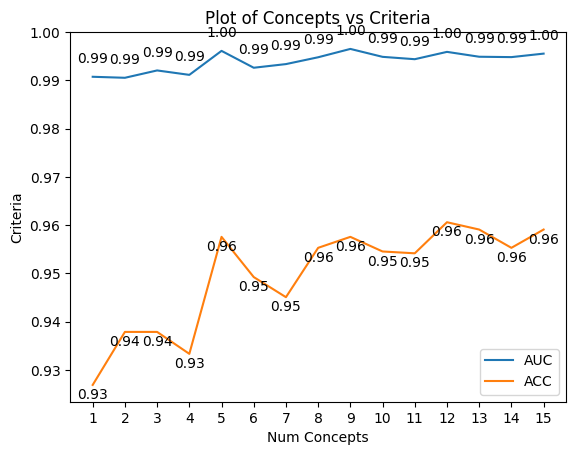

In [16]:
# plot
plt.plot(history_binary[:, 0], history_binary[:, 2], label='AUC')
plt.plot(history_binary[:, 0], history_binary[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_binary[:, 0]), max(history_binary[:, 0])+1, 1))

for x,_y in zip(history_binary[:, 0], history_binary[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_binary[:, 0], history_binary[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend()
plt.show()


In [17]:
# feature weights
n_concepts = 4
_, _, _, model = objective_binary(random_seed, n_concepts, model_path)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c4.pt


0it [00:00, ?it/s]


(4, 182)

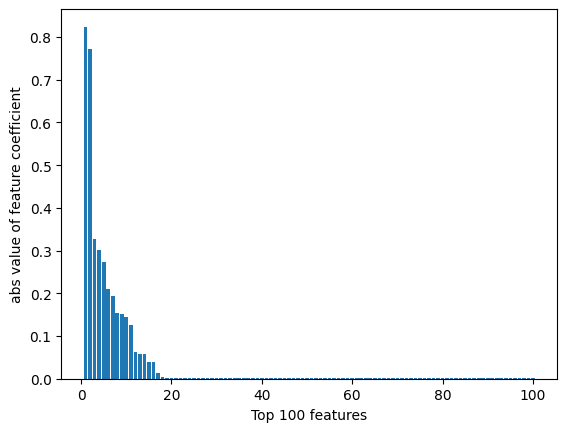

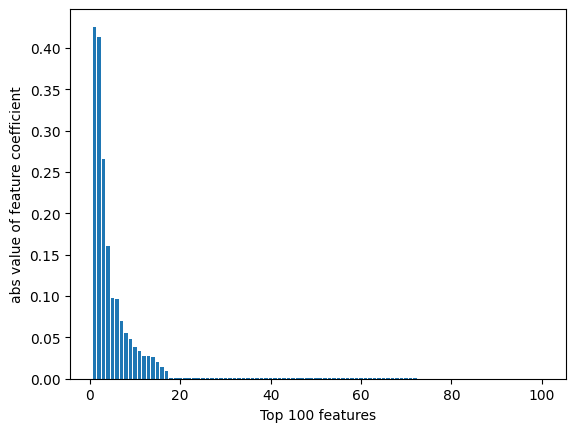

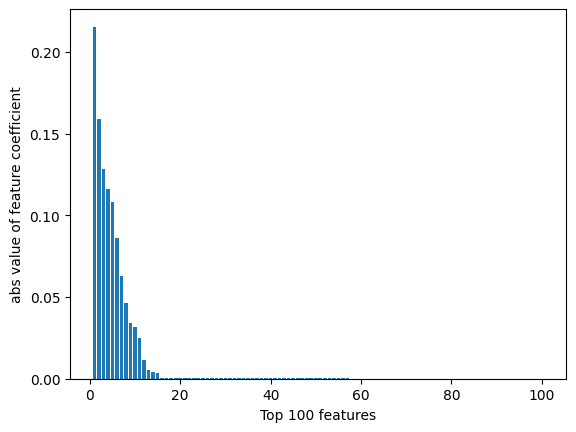

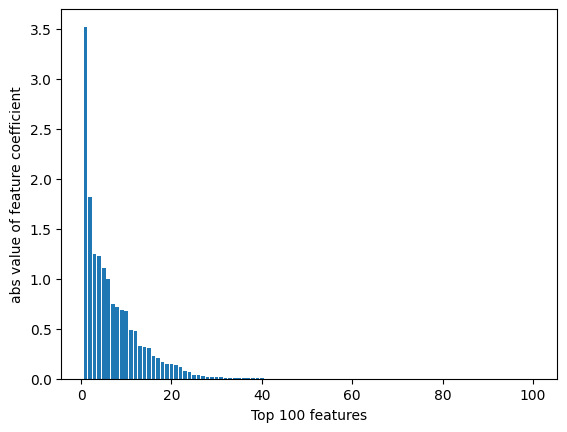

In [19]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [21]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


(4,)

In [28]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    # if len(topkinds_conc) < 10:
    #     topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

[[27, 174, 51, 47, 45, 49, 46, 50, 35, 43],
 [174, 47, 27, 46, 45, 49, 44, 41, 48, 42],
 [46, 48, 51, 43, 27, 49, 50, 40],
 [34, 32, 91, 38, 92, 35, 178, 31, 26, 165, 93, 164, 177, 169]]

In [30]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


## Multi-class

In [31]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

In [32]:
history_multiclass = []
for n_concepts in range(1,16):
    print(n_concepts)
    val_loss, auc, acc, model = objective_multi_class(random_seed, n_concepts, model_path)
    history = [n_concepts, val_loss, auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


1
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c1.pt


0it [00:00, ?it/s]


2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c2.pt


0it [00:00, ?it/s]


3
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c3.pt


0it [00:00, ?it/s]


4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c4.pt


0it [00:00, ?it/s]


5
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c5.pt


0it [00:00, ?it/s]


6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c6.pt


0it [00:00, ?it/s]


7
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c7.pt


0it [00:00, ?it/s]


8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c8.pt


0it [00:00, ?it/s]


9
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c9.pt


0it [00:00, ?it/s]


10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c10.pt


0it [00:00, ?it/s]


11
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c11.pt


0it [00:00, ?it/s]


12
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c12.pt


0it [00:00, ?it/s]


13
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c13.pt


0it [00:00, ?it/s]


14
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c14.pt


0it [00:00, ?it/s]


15
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c15.pt


0it [00:00, ?it/s]


(15, 4)

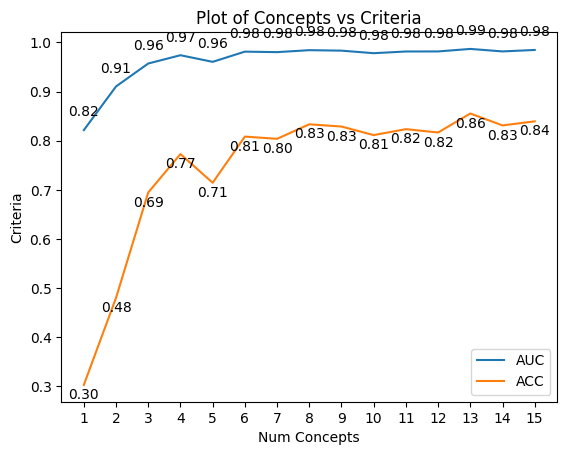

In [33]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [50]:
# feature weights
n_concepts = 1
_, _, _, model = objective_multi_class(random_seed, n_concepts, model_path)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c1.pt


0it [00:00, ?it/s]


(1, 182)

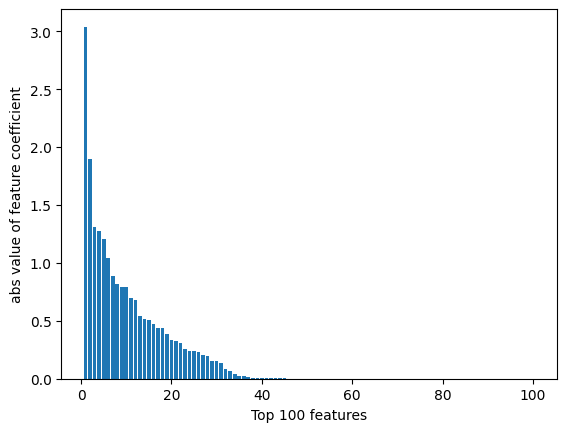

In [51]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [52]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


(1,)

In [57]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    # if len(topkinds_conc) < 10:
    #     topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

str(top_k_inds)

'[[30, 36, 173, 179, 178, 156, 172, 26, 161, 181, 35, 171, 160, 170, 166, 165, 169, 92, 167, 27, 38, 168]]'

In [54]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [55]:
input_dim = 26
changing_dim = 13
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = helper.getConcept(data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


Concept 0: ID 30, Feature 5, Summary mean
Concept 0: ID 36, Feature 11, Summary mean
Concept 0: ID 173, Feature 5, Summary hours below threshold
Concept 0: ID 179, Feature 11, Summary hours below threshold
Concept 0: ID 178, Feature 10, Summary hours below threshold
Concept 0: ID 156, Feature 1, Summary hours above threshold
Concept 0: ID 172, Feature 4, Summary hours below threshold
Concept 0: ID 26, Feature 1, Summary mean
Concept 0: ID 161, Feature 6, Summary hours above threshold
Concept 0: ID 181, Feature 13, Summary hours below threshold
Concept 0: ID 35, Feature 10, Summary mean
Concept 0: ID 171, Feature 3, Summary hours below threshold
Concept 0: ID 160, Feature 5, Summary hours above threshold
Concept 0: ID 170, Feature 2, Summary hours below threshold
Concept 0: ID 166, Feature 11, Summary hours above threshold
Concept 0: ID 165, Feature 10, Summary hours above threshold
Concept 0: ID 169, Feature 1, Summary hours below threshold
Concept 0: ID 92, Feature 2, Summary # switch